In [3]:
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import json
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os



In [5]:
# 1. Load .env into environment
load_dotenv()  

# 2. Read the connection string
AZURE_CONN_STR = os.getenv("AZURE_CONN_STR")
if not AZURE_CONN_STR:
    raise RuntimeError("Missing AZURE_CONN_STR—make sure .env is present and loaded")

# 3. Create the client
service = BlobServiceClient.from_connection_string(AZURE_CONN_STR)

In [6]:
# — mappings from data_type to human-friendly y‐axis label (including units) —
_METRIC_LABELS = {
    "CUR_MKT_CAP":    "Market Cap (MM USD)",
    "DVD_SH_12M":     "Dividends per Share (USD)",
    "EQY_SH_OUT":     "Shares Outstanding (MM)",
    "OPEN_INT_TOTAL_CALL": "Call Open Interest (contracts)",
    "OPEN_INT_TOTAL_PUT":  "Put Open Interest (contracts)",
    "PX_HIGH":        "High Price (USD)",
    "PX_LAST":        "Close Price (USD)",
    "PX_LOW":         "Low Price (USD)",
    "PX_VOLUME":      "Equity Volume",
    "SHORT_INT":      "Short Interest",
    "TOT_OPT_VOLUME_CUR_DAY": "Total Option Volume (contracts)",
    "TOT_RETURN_INDEX_GROSS_DVDS": "Total Return Index (USD)",
    "VOLUME_TOTAL_CALL":      "Call Volume (contracts)",
    "VOLUME_TOTAL_PUT":       "Put Volume (contracts)",
}

In [7]:
def get_figi_for_ticker(service: BlobServiceClient, ticker: str, container_name: str = "mapping", mapping_blob: str = "bloomberg_figi_mapping.json") -> str:
    """
    Fetches the FIGI corresponding to a ticker from the mapping JSON.
    """
    container = service.get_container_client(container_name)
    blob = container.get_blob_client(mapping_blob)
    raw = blob.download_blob().readall()
    mapping = json.loads(raw)
    if ticker not in mapping:
        raise ValueError(f"Ticker '{ticker}' not found in mapping.")
    return mapping[ticker]

In [8]:
def fetch_and_convert(service: BlobServiceClient, data_type: str, ticker: str, mapping_container: str = "mapping", processed_container: str = "processed") -> pd.Series:
    """
    Downloads <data_type>.json for the FIGI mapped from `ticker`,
    and returns a sorted time-indexed pandas Series.
    """
    figi = get_figi_for_ticker(service, ticker, mapping_container)
    container_client = service.get_container_client(processed_container)
    
    # Check if the FIGI subdirectory exists
    prefix = f"historical/{figi}/"
    matching = list(container_client.list_blobs(name_starts_with=prefix))
    if not matching:
        raise FileNotFoundError(
            f"Historical time series data not yet pulled for {ticker}"
        )
    blob_path = f"historical/{figi}/{data_type}.json"
    blob = service.get_container_client(processed_container).get_blob_client(blob_path)
    raw = blob.download_blob().readall()
    obj = json.loads(raw)
    data = obj["data"]

    series = pd.Series(data)
    series.index = pd.to_datetime(series.index)
    series.sort_index(inplace=True)
    series.name = _METRIC_LABELS.get(data_type, data_type)
    return series

In [9]:
def plot_series(series: pd.Series, ticker: str, tick_step: int = 250):
    """
    Plots the given time‐series with inferred labels/title based on ticker.
    """
    tick_step = len(series) // 12
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series.values, label=series.name)
    subset = series.index[::tick_step]
    plt.xticks(subset, rotation=45)
    plt.xlabel("Date")
    plt.ylabel(series.name)
    plt.title(f"{ticker}: {series.name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

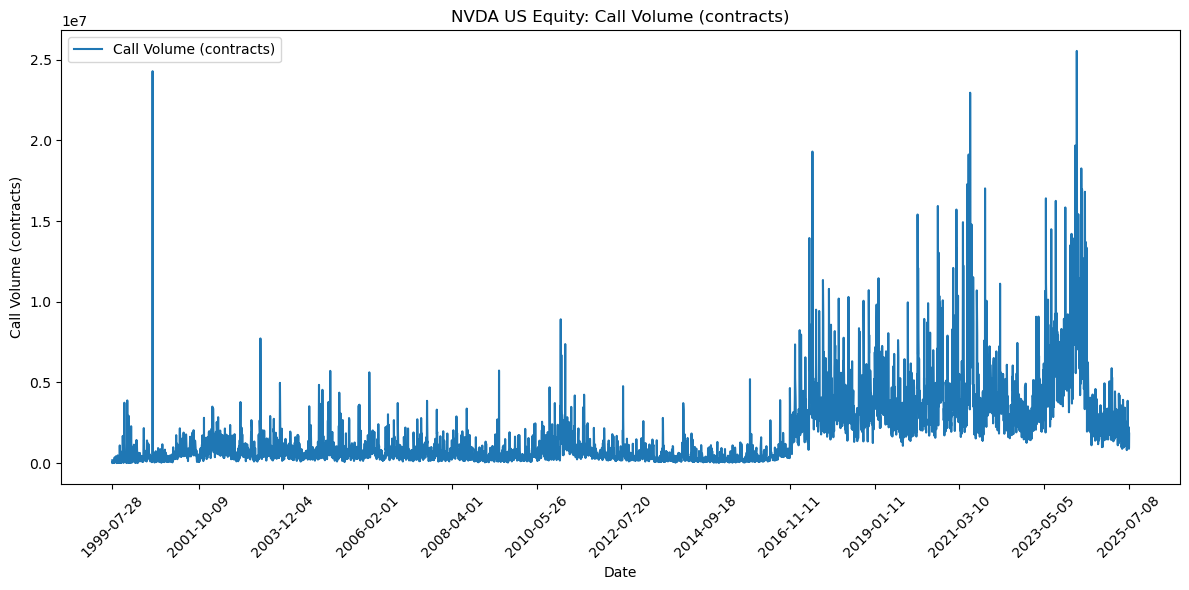

In [10]:
ticker = "NVDA US Equity"
data_type = "VOLUME_TOTAL_CALL"

series = fetch_and_convert(service, data_type, ticker)
plot_series(series, ticker)